<a href="https://colab.research.google.com/github/victorasso/Bosch_Kaggle/blob/master/notebooks/022_lv_normalization_totals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Config

In [ ]:
# fields = [ # blank will get everything from the core
#           'start_date', 'deadline_date', 'creation_date', 'last_modified_date', # dates in grants
#           'end_date', 'start_date', 'publish_date', 'creation_date', 'last_modified_date', # dates in projects
#           'docdb_date', 'epodoc_date', 'publication_date', 'priority_claim_date', 'application_date', 'last_update_date', 'date_of_last_exchange' #dates in all patents cores
#           ] 

# http://35.223.230.190:8983/solr/grants_ip2/select?indent=on&q=nanotechnology&wt=json # grants_ip2
# http://35.223.230.190:8983/solr/funded_projects_marvin/select?indent=on&q={q}&wt=json # funded_projects_marvin
# http://35.223.230.190:8983/solr/patents-ep/select?indent=on&q=nanotechnology&wt=json # patents-ep
# http://35.223.230.190:8983/solr/patents-other/select?indent=on&q=nanotechnology&wt=json # patents-other
# http://35.223.230.190:8983/solr/patents-pc/select?indent=on&q=nanotechnology&wt=json # patents-pc

In [ ]:
import requests
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from requests.auth import HTTPBasicAuth

warnings.filterwarnings('ignore')

usr, pwd = 'picampus', 'a!5chool.2021'

# Helper functions

In [ ]:
def get_query_count(q, dataset):
  url = f'http://35.223.230.190:8983/solr/{dataset}/select?indent=on&q={q}&rows=0&wt=json'
  r = requests.get(url, auth=HTTPBasicAuth(usr, pwd))
  result = r.json()
  return result['response']['numFound']


def get_documents(q, dataset):
  total_documents = get_query_count(q, dataset)

  url = f'http://35.223.230.190:8983/solr/{dataset}/select?indent=on&q={q}&fl={fields}&rows={total_documents}&wt=json'
  r = requests.get(url, auth=HTTPBasicAuth(usr, pwd))

  result = r.json()
  result = result['response']['docs']
  
  results = []
  for r in result:
    results.append(r)

  return results

# Dataset buildier

For any query, this will return the monthly document counts across all cores

## Get the monthly document counts

In [ ]:
def get_montlhy_documents(q, dataset):
  result = get_documents(q, dataset)
  df = pd.DataFrame(result)
  df.columns = ['date']

  df = df.dropna()
  df['date'] = pd.to_datetime(df['date'])

  df = pd.DataFrame(df['date'].groupby(df.date.dt.to_period("M")).size().rename(f'{dataset}_documents'))

  return df

def get_monthly_all_cores(q):

  dfs = []
  for dataset in datasets:
    for core in datasets[dataset]:
      dfs.append(get_montlhy_documents(q, core))

  df = pd.concat(dfs, axis=1)
  #df = df.fillna(0)
  df['query'] = q
  return df

In [ ]:
# parameters

# fields to extract, all dates are in the config section
fields = [ # blank will get everything from the core
          'deadline_date', # dates in grants
          'publish_date',  # dates in projects
          'publication_date', #dates in all patents cores
          'date_published' # dates in the papers core
          ] 

fields = ','.join(fields)

# dataset and solr core paths
datasets = {
    'grants': ['grants_ip2'],
    'projects': ['funded_projects_marvin'],
    'patents': ['patents-ep', 'patents-other', 'patents-pc'],
    'papers': ['lens_papers']
    }

,grants_ip2_documents,funded_projects_marvin_documents,patents-ep_documents,patents-other_documents,patents-pc_documents,lens_papers_documents,query
date,,,,,,,
1988-03,NaN,NaN,NaN,1.0,NaN,NaN,nanotechnology
1991-10,NaN,NaN,NaN,1.0,NaN,NaN,nanotechnology
1992-03,NaN,NaN,NaN,1.0,NaN,NaN,nanotechnology
1992-07,NaN,NaN,NaN,NaN,1.0,NaN,nanotechnology
1992-08,NaN,NaN,NaN,NaN,1.0,NaN,nanotechnology
...,...,...,...,...,...,...,...
2021-07,2.0,NaN,NaN,NaN,NaN,8.0,nanotechnology
2021-09,3.0,NaN,NaN,NaN,NaN,NaN,nanotechnology
2022-12,1.0,NaN,NaN,NaN,NaN,NaN,nanotechnology


CPU times: user 387 ms, sys: 24.3 ms, total: 411 ms
Wall time: 4.21 s


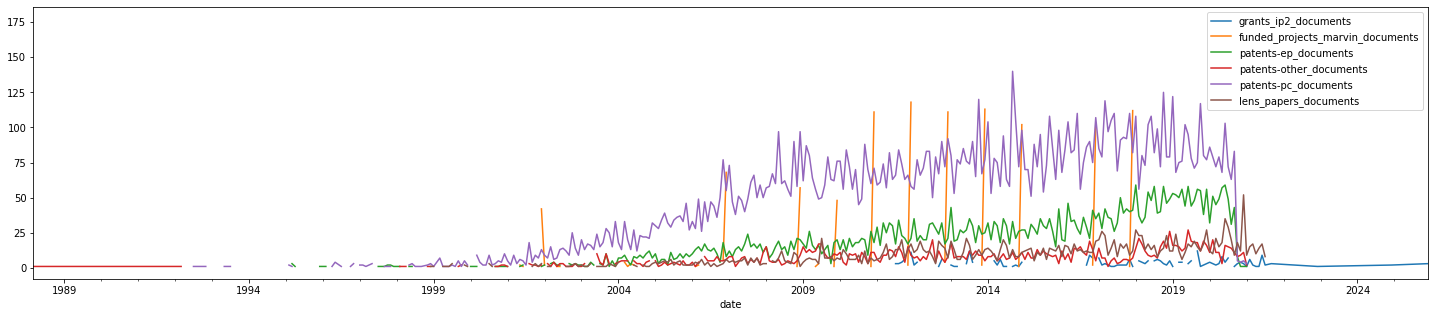

In [ ]:
%%time
q = 'nanotechnology'

df = get_monthly_all_cores(q)
display(df)

plt.rcParams["figure.figsize"] = (25,5)
df.plot()

# Null analysis

In [ ]:
q = 'nanotechnology'

for dataset in datasets:
  for core in datasets[dataset]:
    result = get_documents(q, core)
    df = pd.DataFrame(result)
    df.columns = ['date']

    print('{}: null count: {:.2f}% [{}/{}]'.format(core, df['date'].isnull().sum() / df.shape[0] * 100, df['date'].isnull().sum(), df.shape[0]))

grants_ip2: null count: 39.05% [198/507]
funded_projects_marvin: null count: 58.40% [2495/4272]
patents-ep: null count: 0.00% [0/5162]
patents-other: null count: 0.00% [0/1845]
patents-pc: null count: 0.00% [0/14328]
lens_papers: null count: 49.72% [2204/4433]


## Get text data

In [ ]:
def get_query_count(q, dataset):
  url = f'http://35.223.230.190:8983/solr/{dataset}/select?indent=on&q={q}&rows=0&wt=json'
  r = requests.get(url, auth=HTTPBasicAuth(usr, pwd))
  result = r.json()
  return result['response']['numFound']



def get_documents(q, dataset):
  total_documents = get_query_count(q, dataset)

  url = f'http://35.223.230.190:8983/solr/{dataset}/select?indent=on&q={q}&fl={fields}&rows={total_documents}&wt=json'
  r = requests.get(url, auth=HTTPBasicAuth(usr, pwd))

  result = r.json()

  result = result['response']['docs']

  return result

# Create sectors and queries from the projects dataset

In [ ]:
q = '*'  # query '*' to get all

fields = ['fields_of_study', 'source_asjc_subjects']  # fields to extract, all dates are in the config section
fields = ','.join(fields)

results = get_documents(q, 'lens_papers')
print('found: {}'.format(len(results)))

found: 4710224


In [ ]:
out = []
for result in results:
  if result:
    out.append(result)

print('Non null records for selected fields: {}'.format(len(out)))

Non null records for selected fields: 4354143


In [ ]:
df = pd.DataFrame(out)
df

,fields_of_study,source_asjc_subjects
0,"[Thermal spraying, Metallurgy, Materials scien...",NaN
1,"[Biomass (ecology), Invertebrate, Respiration,...",NaN
2,"[Hexagonal crystal system, Lattice (order), Ma...",NaN
3,"[Magnetic field, Physics, Position (vector), V...",NaN
4,"[Air permeability specific surface, Polyester,...",NaN
...,...,...
4354138,"[Climate change, Minamata Convention on Mercur...",NaN
4354139,NaN,"[Astronomy and Astrophysics, Space and Planeta..."
4354140,"[Epidemiology, Cross-sectional study, Demograp...","[General Medicine, Epidemiology]"
4354141,"[Fermentation, Biosorption, Cadmium chloride, ...","[Health, Toxicology and Mutagenesis, Environme..."


In [ ]:
fields = []

f_list = df['fields_of_study'].dropna().tolist()

for l in tqdm(f_list):
  for f in l:
    fields.append(f)

fields = set(fields)

print('fields_of_study unique: {}\n{}'.format(len(fields), fields))

100%|██████████| 4074042/4074042 [00:06<00:00, 597447.88it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




In [ ]:
print('fields_of_study unique: {}'.format(len(fields)))
print(list(fields)[:200])

fields_of_study unique: 247194
['Galium spurium', 'Detrended fluctuation analysis', 'Metalloprotein', 'Obestatin', 'Tumor angiogenesis', 'Piptatheropsis', 'Watt second', 'Wifi network', 'Discorbis', 'Stroop effect', 'Tmj dysfunction', 'CW Doppler', 'X-linked adrenal hypoplasia congenita', 'Nursing shortage', 'Af ablation', 'Adrenocortical adenoma', 'Verification bias', 'Subtractive color', 'Diffusive conductance', 'Apeltes quadracus', 'Law of sines', 'Shifting attention', 'Water discharge', 'Phymatolithon repandum', 'Synaptula', 'Urologic Surgical Procedure', '2-(5-bromo-2-pyridylazo)-5-diethylaminophenol', 'Alloy coating', 'Viscous boundary layer', 'Medial cortex', 'L-Deprenyl', 'Rasa shastra', 'Symmetry operation', 'Young tree', 'Selectivity', 'Isotope fractionation', 'Anti-corrosion', 'Natural dye', 'Humantenmine', 'Pruritus vulvae', 'Ecological agriculture', 'Analog high-definition television system', 'Induced gamma emission', 'Satellite payload', 'Direct borohydride fuel cell', 'L

In [ ]:
asjcs = []

f_list = df['source_asjc_subjects'].dropna().tolist()

for l in tqdm(f_list):
  for f in l:
    asjcs.append(f)

asjcs = set(asjcs)

print('source_asjc_subjects unique: {}\n{}'.format(len(asjcs), asjcs))

100%|██████████| 2360732/2360732 [00:02<00:00, 1034356.37it/s]

source_asjc_subjects unique: 331
{'Sensory Systems', 'Dental Hygiene', 'Biochemistry', 'Structural Biology', 'Social Sciences (miscellaneous)', 'Atomic and Molecular Physics, and Optics', 'Statistics, Probability and Uncertainty', 'Astronomy and Astrophysics', 'Occupational Therapy', 'Neuropsychology and Physiological Psychology', 'Management, Monitoring, Policy and Law', 'Transportation', 'Chemistry (miscellaneous)', 'Architecture ', 'Orthodontics', 'General Materials Science', 'Logic', 'Nursing (miscellaneous)', 'Decision Sciences (miscellaneous)', 'Reviews and References, Medical', 'General Computer Science', 'Health Professions (miscellaneous)', 'Urban Studies', 'Pharmacology, Toxicology and Pharmaceutics (miscellaneous)', 'Phychiatric Mental Health', 'Museology', 'Signal Processing', 'Mathematical Physics', 'Medical Laboratory Technology', 'Hematology', 'Plant Science', 'Catalysis', 'Public Administration', 'General Dentistry', 'Pediatrics, Perinatology, and Child Health', 'Oceano

In [ ]:
df.dropna()

,fields_of_study,source_asjc_subjects
7,"[Air conditioning, Engineering, Daylight, Nois...",[General Engineering]
12,"[Fabrication, Chemical composition, Particle s...","[Metals and Alloys, General Chemical Engineeri..."
13,"[Physics, Nusselt number, Grashof number, Equi...","[Condensed Matter Physics, Mechanical Engineer..."
14,"[Analytical chemistry, Infrared spectroscopy, ...","[Energy Engineering and Power Technology, Fuel..."
17,"[Analytical chemistry, Chemistry, Atmospheric ...","[General Engineering, General Physics and Astr..."
...,...,...
4354135,"[Calcareous, Salinity, Leaching (agriculture),...","[Waste Management and Disposal, Water Science ..."
4354136,[Environmental impact of pharmaceuticals and p...,"[Health, Toxicology and Mutagenesis, Environme..."
4354140,"[Epidemiology, Cross-sectional study, Demograp...","[General Medicine, Epidemiology]"
4354141,"[Fermentation, Biosorption, Cadmium chloride, ...","[Health, Toxicology and Mutagenesis, Environme..."
